# Bibliotecas

In [106]:
# Manipulação e estruturação
import pandas as pd
import numpy as np

# Modelagem
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit

# Avaliação
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Pré-processamento
from sklearn.preprocessing import StandardScaler

# Visualização
import matplotlib.pyplot as plt



### Médias móveis

# Treinamento 2010 - 2021

## Preparação dos Dados

In [107]:
df = pd.read_csv("../../camada_ouro/Join_dataframes_new_end.csv", parse_dates=["Date"])
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [108]:
# Limpeza de colunas com %
df['Change%_Petro'] = df['Change%_Petro'].str.replace('%', '').astype(float) / 100
df['Value_IPCA'] = df['Value_IPCA'].str.replace('%', '').astype(float) / 100
df['Change%_Ibovespa'] = df['Change%_Ibovespa'].astype("str")
df['Change%_Ibovespa'] = df['Change%_Ibovespa'].str.replace('%', '').astype(float) / 100

display(df)

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA
0,2010-01-04,2010-01-04 16:56:00,37.937621,13303743.87,22.005581,81.51,263.54,0.0271,70045.08,0.003999,0.0075
1,2010-01-05,2010-01-05 16:56:00,37.774220,21396519.48,21.927335,81.77,258.89,0.0032,70239.82,-0.037754,0.0075
2,2010-01-06,2010-01-06 16:56:00,38.805357,18720547.15,22.382971,83.18,370.06,0.0172,70729.34,-0.025855,0.0075
3,2010-01-07,2010-01-07 16:56:00,36.425929,10964646.19,20.918813,82.66,246.63,-0.0063,70451.12,0.012930,0.0075
4,2010-01-08,2010-01-08 16:56:00,35.037787,14624078.31,20.148239,82.75,310.38,0.0011,70262.70,0.013341,0.0075
...,...,...,...,...,...,...,...,...,...,...,...
3626,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-0.068388,0.0052
3627,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-0.065514,0.0052
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,0.0052
3629,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-0.057957,0.0052


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3631 entries, 0 to 3630
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               3631 non-null   datetime64[ns]
 1   Datetime           3631 non-null   object        
 2   Close_Real_EYAC2   3631 non-null   float64       
 3   Volume_EYAC2       3631 non-null   float64       
 4   Close_Dolar_EYAC2  3631 non-null   float64       
 5   Price_Dolar_Petro  3631 non-null   float64       
 6   Volume_Petro       3631 non-null   float64       
 7   Change%_Petro      3631 non-null   float64       
 8   Índice_Ibovespa    3631 non-null   float64       
 9   Change%_Ibovespa   3631 non-null   float64       
 10  Value_IPCA         3631 non-null   float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 312.2+ KB


## Alvo

In [110]:
df['target'] = df['Close_Dolar_EYAC2'].shift(-1)  # prever o preço da ação no próximo dia

## Feature Engineering 

### Retornos percentuais diários

In [111]:
df['retorno_acao'] = df['Close_Dolar_EYAC2'].pct_change()
df['retorno_petro'] = df['Price_Dolar_Petro'].pct_change()

df.tail()


,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro
3626,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-0.068388,0.0052,7.206377,0.065247,-0.005189
3627,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-0.065514,0.0052,6.977118,0.011586,-0.003043
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,0.0052,6.597186,-0.031813,0.006104
3629,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-0.057957,0.0052,6.605965,-0.054454,0.013722
3630,2024-12-30,2024-12-30 16:56:00,36.614223,22355586.67,6.605965,70.53,93.10,0.0050,120283.40,-0.079271,0.0052,NaN,0.001331,0.004987


### Médias móveis

In [112]:
df['mm7_acao'] = df['Close_Dolar_EYAC2'].rolling(7).mean()

df.tail()

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,mm7_acao
3626,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-0.068388,0.0052,7.206377,0.065247,-0.005189,6.743059
3627,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-0.065514,0.0052,6.977118,0.011586,-0.003043,6.773660
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,0.0052,6.597186,-0.031813,0.006104,6.841087
3629,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-0.057957,0.0052,6.605965,-0.054454,0.013722,6.802652
3630,2024-12-30,2024-12-30 16:56:00,36.614223,22355586.67,6.605965,70.53,93.10,0.0050,120283.40,-0.079271,0.0052,NaN,0.001331,0.004987,6.837876


### Volatilidade

In [113]:
df['vol_7_acao'] = df['Close_Dolar_EYAC2'].rolling(7).std()
df['vol_30_acao'] = df['Close_Dolar_EYAC2'].rolling(30).std()

df.tail()

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,mm7_acao,vol_7_acao,vol_30_acao
3626,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-0.068388,0.0052,7.206377,0.065247,-0.005189,6.743059,0.269219,0.353354
3627,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-0.065514,0.0052,6.977118,0.011586,-0.003043,6.773660,0.311161,0.351737
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,0.0052,6.597186,-0.031813,0.006104,6.841087,0.293936,0.351622
3629,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-0.057957,0.0052,6.605965,-0.054454,0.013722,6.802652,0.307383,0.349988
3630,2024-12-30,2024-12-30 16:56:00,36.614223,22355586.67,6.605965,70.53,93.10,0.0050,120283.40,-0.079271,0.0052,NaN,0.001331,0.004987,6.837876,0.258339,0.353756


### Defasagens

In [114]:
df['lag1_acao'] = df['Close_Dolar_EYAC2'].shift(1)
df['lag60_acao'] = df['Close_Dolar_EYAC2'].shift(60)

df.tail()

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
3626,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-0.068388,0.0052,7.206377,0.065247,-0.005189,6.743059,0.269219,0.353354,6.687504,7.134576
3627,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-0.065514,0.0052,6.977118,0.011586,-0.003043,6.773660,0.311161,0.351737,7.123841,6.470556
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,0.0052,6.597186,-0.031813,0.006104,6.841087,0.293936,0.351622,7.206377,7.059024
3629,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-0.057957,0.0052,6.605965,-0.054454,0.013722,6.802652,0.307383,0.349988,6.977118,6.209937
3630,2024-12-30,2024-12-30 16:56:00,36.614223,22355586.67,6.605965,70.53,93.10,0.0050,120283.40,-0.079271,0.0052,NaN,0.001331,0.004987,6.837876,0.258339,0.353756,6.597186,6.688640


In [115]:
df_test = df[['Date','target','retorno_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao','lag1_acao', 'lag60_acao']]
display(df_test)

,Date,target,retorno_acao,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
0,2010-01-04,21.927335,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,22.382971,-0.003556,NaN,NaN,NaN,22.005581,NaN
2,2010-01-06,20.918813,0.020779,NaN,NaN,NaN,21.927335,NaN
3,2010-01-07,20.148239,-0.065414,NaN,NaN,NaN,22.382971,NaN
4,2010-01-08,20.841494,-0.036836,NaN,NaN,NaN,20.918813,NaN
...,...,...,...,...,...,...,...,...
3626,2024-12-20,7.206377,0.065247,6.743059,0.269219,0.353354,6.687504,7.134576
3627,2024-12-23,6.977118,0.011586,6.773660,0.311161,0.351737,7.123841,6.470556
3628,2024-12-26,6.597186,-0.031813,6.841087,0.293936,0.351622,7.206377,7.059024
3629,2024-12-27,6.605965,-0.054454,6.802652,0.307383,0.349988,6.977118,6.209937


## Tratamento dos dados

Essas transformações geram valores NaN no início da série, por exemplo:

pct_change() → NaN na primeira linha

rolling(7).mean() → NaN nas 6 primeiras linhas

shift(1) → NaN na primeira linha

Esses NaNs atrapalham o treino do modelo e precisam ser removidos antes de separar treino/teste ou aplicar model.fit().

In [116]:
# Copiar o DataFrame original para df_model
df_nan = df.copy()

# Preencher os NaN restantes usando o valor posterior (bfill)
df_nan[['lag1_acao', 'lag60_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 
          'retorno_acao', 'retorno_petro',]] = \
df_nan[['lag1_acao', 'lag60_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 
          'retorno_acao', 'retorno_petro',]].fillna(method='bfill')

# Verificar se ainda há NaN após preenchimento com bfill 
nan_counts_after_filling = df_nan[['lag1_acao', 'lag60_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 
          'retorno_acao', 'retorno_petro',]].isna().sum()

print("Após interpolação e bfill, contagem de NaN:", nan_counts_after_filling)

# Visualizar as primeiras linhas após o preenchimento
print(df_nan.head())


Após interpolação e bfill, contagem de NaN: lag1_acao        0
lag60_acao       0
mm7_acao         0
vol_7_acao       0
vol_30_acao      0
retorno_acao     0
retorno_petro    0
dtype: int64
        Date             Datetime  Close_Real_EYAC2  Volume_EYAC2  \
0 2010-01-04  2010-01-04 16:56:00         37.937621   13303743.87   
1 2010-01-05  2010-01-05 16:56:00         37.774220   21396519.48   
2 2010-01-06  2010-01-06 16:56:00         38.805357   18720547.15   
3 2010-01-07  2010-01-07 16:56:00         36.425929   10964646.19   
4 2010-01-08  2010-01-08 16:56:00         35.037787   14624078.31   

   Close_Dolar_EYAC2  Price_Dolar_Petro  Volume_Petro  Change%_Petro  \
0          22.005581              81.51        263.54         0.0271   
1          21.927335              81.77        258.89         0.0032   
2          22.382971              83.18        370.06         0.0172   
3          20.918813              82.66        246.63        -0.0063   
4          20.148239              8

C:\Users\FM972EJ\AppData\Local\Temp\ipykernel_26636\4236721217.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  'retorno_acao', 'retorno_petro',]].fillna(method='bfill')


In [117]:
df_nan.isna().sum()

Date                 0
Datetime             0
Close_Real_EYAC2     0
Volume_EYAC2         0
Close_Dolar_EYAC2    0
Price_Dolar_Petro    0
Volume_Petro         0
Change%_Petro        0
Índice_Ibovespa      0
Change%_Ibovespa     0
Value_IPCA           0
target               1
retorno_acao         0
retorno_petro        0
mm7_acao             0
vol_7_acao           0
vol_30_acao          0
lag1_acao            0
lag60_acao           0
dtype: int64

In [118]:
df_model = df_nan.dropna().copy()   

df_model.tail(2)

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,0.0052,6.597186,-0.031813,0.006104,6.841087,0.293936,0.351622,7.206377,7.059024
3629,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-0.057957,0.0052,6.605965,-0.054454,0.013722,6.802652,0.307383,0.349988,6.977118,6.209937


In [119]:
df_model.isna().sum()

Date                 0
Datetime             0
Close_Real_EYAC2     0
Volume_EYAC2         0
Close_Dolar_EYAC2    0
Price_Dolar_Petro    0
Volume_Petro         0
Change%_Petro        0
Índice_Ibovespa      0
Change%_Ibovespa     0
Value_IPCA           0
target               0
retorno_acao         0
retorno_petro        0
mm7_acao             0
vol_7_acao           0
vol_30_acao          0
lag1_acao            0
lag60_acao           0
dtype: int64

In [120]:
df_test1 = df_model[['Date','target','retorno_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao','lag1_acao', 'lag60_acao']]
display(df_test1)


,Date,target,retorno_acao,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
0,2010-01-04,21.927335,-0.003556,21.529332,0.891876,1.705580,22.005581,22.005581
1,2010-01-05,22.382971,-0.003556,21.529332,0.891876,1.705580,22.005581,22.005581
2,2010-01-06,20.918813,0.020779,21.529332,0.891876,1.705580,21.927335,22.005581
3,2010-01-07,20.148239,-0.065414,21.529332,0.891876,1.705580,22.382971,22.005581
4,2010-01-08,20.841494,-0.036836,21.529332,0.891876,1.705580,20.918813,22.005581
...,...,...,...,...,...,...,...,...
3625,2024-12-19,7.123841,0.003055,6.774177,0.326964,0.354427,6.667138,6.890756
3626,2024-12-20,7.206377,0.065247,6.743059,0.269219,0.353354,6.687504,7.134576
3627,2024-12-23,6.977118,0.011586,6.773660,0.311161,0.351737,7.123841,6.470556
3628,2024-12-26,6.597186,-0.031813,6.841087,0.293936,0.351622,7.206377,7.059024


In [121]:

data_reduced = df_model.drop(columns=['Date','Datetime'])

# Calcular a variabilidade (desvio padrão) das features numéricas restantes
variability = data_reduced.std()

# Calcular a correlação entre as features
correlation_matrix = data_reduced.corr()

# Exibir a variabilidade
print("Variabilidade das Features:")
display(variability)

# Exibir a matriz de correlação
print("Matriz de Correlação das Features:")
display(correlation_matrix)

Variabilidade das Features:


Close_Real_EYAC2     8.355212e+00
Volume_EYAC2         3.241283e+07
Close_Dolar_EYAC2    3.895470e+00
Price_Dolar_Petro    2.098516e+01
Volume_Petro         1.660087e+02
Change%_Petro        2.724452e-02
Índice_Ibovespa      2.752411e+04
Change%_Ibovespa     8.946320e-02
Value_IPCA           3.609585e-03
target               3.887852e+00
retorno_acao         1.336220e-01
retorno_petro        2.455251e-02
mm7_acao             3.877006e+00
vol_7_acao           2.791585e-01
vol_30_acao          3.073418e-01
lag1_acao            3.903067e+00
lag60_acao           4.321538e+00
dtype: float64

Matriz de Correlação das Features:


,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
Close_Real_EYAC2,1.000000,-0.015574,0.429409,0.366131,-0.353437,0.003342,0.783965,0.122858,-0.102776,0.406352,0.054894,0.019900,0.406509,-0.143262,-0.118916,0.404946,0.295901
Volume_EYAC2,-0.015574,1.000000,-0.430554,-0.282602,0.001013,0.031350,0.268353,-0.073720,0.050002,-0.432390,-0.008031,0.010727,-0.428711,-0.305228,-0.271974,-0.425570,-0.404261
Close_Dolar_EYAC2,0.429409,-0.430554,1.000000,0.583168,-0.087977,-0.012152,-0.152875,0.070683,-0.051955,0.980099,0.039422,0.004532,0.988772,0.610918,0.664750,0.980177,0.926351
Price_Dolar_Petro,0.366131,-0.282602,0.583168,1.000000,-0.289808,-0.008427,-0.037469,0.028943,0.051523,0.583106,-0.038962,0.026292,0.586096,0.387607,0.363662,0.582059,0.514979
Volume_Petro,-0.353437,0.001013,-0.087977,-0.289808,1.000000,0.008648,-0.334465,-0.057120,0.008408,-0.088895,0.014132,-0.005885,-0.083152,0.094460,0.076256,-0.083448,-0.066374
Change%_Petro,0.003342,0.031350,-0.012152,-0.008427,0.008648,1.000000,0.014480,0.010462,-0.004649,-0.009041,0.063802,0.857795,-0.022891,-0.020767,-0.024511,-0.024972,-0.021452
Índice_Ibovespa,0.783965,0.268353,-0.152875,-0.037469,-0.334465,0.014480,1.000000,0.116297,-0.057654,-0.152719,-0.036111,0.019171,-0.158482,-0.531622,-0.545677,-0.154143,-0.230101
Change%_Ibovespa,0.122858,-0.073720,0.070683,0.028943,-0.057120,0.010462,0.116297,1.000000,-0.027156,0.071819,0.006727,0.052637,0.057138,0.000037,-0.122352,0.067629,-0.063876
Value_IPCA,-0.102776,0.050002,-0.051955,0.051523,0.008408,-0.004649,-0.057654,-0.027156,1.000000,-0.052982,0.011407,0.018888,-0.049273,-0.001055,0.018240,-0.050546,-0.030564
target,0.406352,-0.432390,0.980099,0.583106,-0.088895,-0.009041,-0.152719,0.071819,-0.052982,1.000000,-0.030570,0.006358,0.984608,0.610155,0.664122,0.976746,0.925395


## Definindo Features e Target

In [122]:
# Atualizando as features
feature_names = ['lag1_acao',
                  'lag60_acao',
                    'mm7_acao',
                      'vol_7_acao',
                        'vol_30_acao',
                          'Price_Dolar_Petro',
                            'Índice_Ibovespa',
                              'retorno_acao',
                                'retorno_petro']


# Definindo X (features) e y (target)
X = df_model[feature_names]
y = df_model['target']

## Padronização

In [123]:
# Inicializando o scaler
scaler = StandardScaler()

# Padronizando as features
X_scaled = scaler.fit_transform(X)

## Separar Treino e teste

In [124]:
split_date = '2022-01-01'

train = df_model[df_model['Date'] < split_date]     # Treinamento: 2010–2021
test = df_model[df_model['Date'] >= split_date]     # Teste: 2022–2024

X_train = train[feature_names]
y_train = train['target']
X_test = test[feature_names]
y_test = test['target']

# Padronizando os dados de treino e teste
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [125]:

from sklearn.feature_selection import RFE
# Definir o modelo Ridge
ridge_model = Ridge(alpha=0.1)

# Aplicar o RFE (Selecionar as 5 melhores features)
selector = RFE(ridge_model, n_features_to_select=9)  # Alterar o número de features se necessário
selector = selector.fit(X_train_scaled, y_train)

# Mostrar as features selecionadas
selected_features = [f for f, s in zip(feature_names, selector.support_) if s]
print(f"Features selecionadas: {selected_features}")


Features selecionadas: ['lag1_acao', 'lag60_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 'Price_Dolar_Petro', 'Índice_Ibovespa', 'retorno_acao', 'retorno_petro']


## Treinamento e Validação

### RandomForest

In [126]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Avaliação de desempenho
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest - MAE:", mae_rf)
print("Random Forest - RMSE:", rmse_rf)
print("Random Forest - R²:", r2_rf)


Random Forest - MAE: 0.34596728049400377
Random Forest - RMSE: 0.4343465691468799
Random Forest - R²: 0.8618028047235516


### LinearRegression

In [127]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

# Avaliação de desempenho
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression - MAE:", mae_lr)
print("Linear Regression - RMSE:", rmse_lr)
print("Linear Regression - R²:", r2_lr)


Linear Regression - MAE: 0.3188324627297713
Linear Regression - RMSE: 0.40402273117208815
Linear Regression - R²: 0.8804256473180846


### RidgeRegression

In [128]:
ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Avaliação de desempenho
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression - MAE:", mae_ridge)
print("Ridge Regression - RMSE:", rmse_ridge)
print("Ridge Regression - R²:", r2_ridge)


Ridge Regression - MAE: 0.3190256808661751
Ridge Regression - RMSE: 0.4043838730814869
Ridge Regression - R²: 0.8802117850438059


### LassoRegression

In [129]:
lasso_model = Lasso()
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Avaliação de desempenho
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Lasso Regression - MAE:", mae_lasso)
print("Lasso Regression - RMSE:", rmse_lasso)
print("Lasso Regression - R²:", r2_lasso)


Lasso Regression - MAE: 0.4352117635851793
Lasso Regression - RMSE: 0.5370455305254466
Lasso Regression - R²: 0.7887247367933601


### XGBoost

In [130]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Avaliação de desempenho
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost - MAE:", mae_xgb)
print("XGBoost - RMSE:", rmse_xgb)
print("XGBoost - R²:", r2_xgb)


XGBoost - MAE: 0.4199998783100337
XGBoost - RMSE: 0.5427757292447215
XGBoost - R²: 0.7841921305233959


### Comparação entre modelos

In [131]:
# Criar um DataFrame para comparar as métricas
results = pd.DataFrame({
    'Model': ['Random Forest', 'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'XGBoost'],
    'MAE': [mae_rf, mae_lr, mae_ridge, mae_lasso, mae_xgb],
    'RMSE': [rmse_rf, rmse_lr, rmse_ridge, rmse_lasso, rmse_xgb],
    'R²': [r2_rf, r2_lr, r2_ridge, r2_lasso, r2_xgb]
})

display(results)

,Model,MAE,RMSE,R²
0,Random Forest,0.345967,0.434347,0.861803
1,Linear Regression,0.318832,0.404023,0.880426
2,Ridge Regression,0.319026,0.404384,0.880212
3,Lasso Regression,0.435212,0.537046,0.788725
4,XGBoost,0.420000,0.542776,0.784192


### Validação cruzada temporal

In [132]:
# Definindo TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # 5 divisões

# Função para avaliar cada modelo com TimeSeriesSplit
def evaluate_model_with_ts_split(model, X_train, y_train):
    mae_list = []
    rmse_list = []
    r2_list = []

    for train_index, val_index in tscv.split(X_train):
        X_train_split, X_val_split = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_split, y_val_split = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Treinando o modelo
        model.fit(X_train_split, y_train_split)
        
        # Fazendo previsões
        y_pred = model.predict(X_val_split)
        
        # Calculando as métricas
        mae = mean_absolute_error(y_val_split, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val_split, y_pred))
        r2 = r2_score(y_val_split, y_pred)
        
        # Armazenando as métricas para o split
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
    # Calculando as médias das métricas
    mean_mae = np.mean(mae_list)
    mean_rmse = np.mean(rmse_list)
    mean_r2 = np.mean(r2_list)
    
    return mean_mae, mean_rmse, mean_r2

# Avaliação de cada modelo com TimeSeriesSplit
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

# Armazenando os resultados
results = []

# Avaliar todos os modelos
for name, model in models.items():
    mae, rmse, r2 = evaluate_model_with_ts_split(model, X_train, y_train)
    results.append([name, mae, rmse, r2])

# Criando um DataFrame com os resultados
results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE', 'R²'])
display(results_df)


,Model,MAE,RMSE,R²
0,Random Forest,1.391337,1.610400,-0.307426
1,Linear Regression,0.587505,0.730913,0.664589
2,Ridge Regression,0.581217,0.723812,0.665094
3,Lasso Regression,1.468037,1.679615,-1.187871
4,XGBoost,1.558181,1.807783,-0.526372


## Visualização (melhor modelo, Ridge)

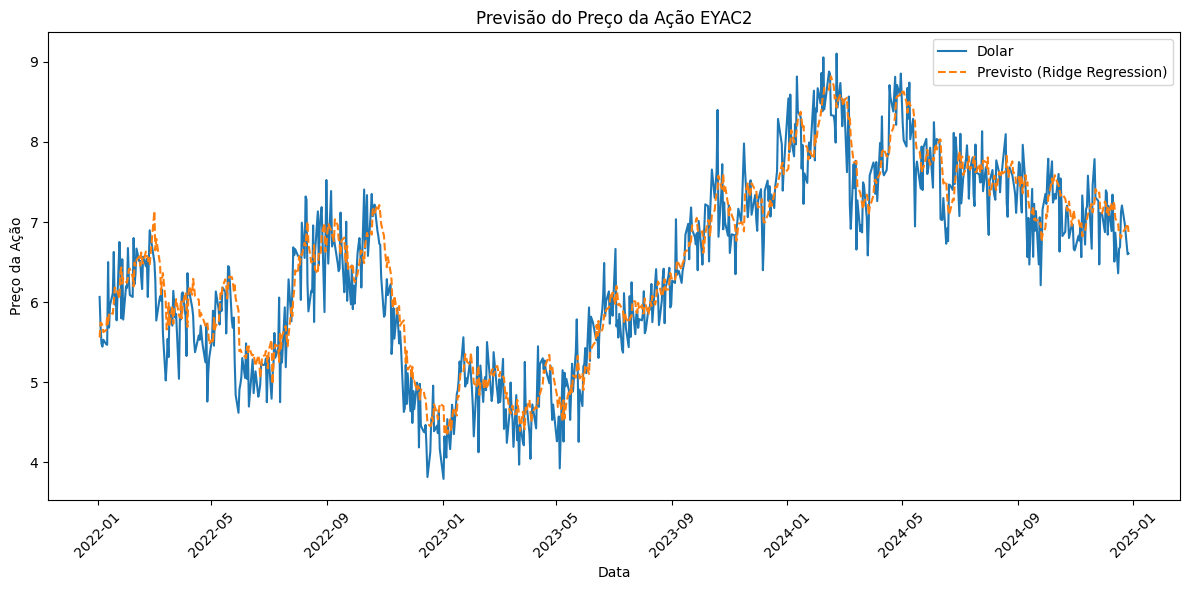

In [133]:
# Plotando as previsões vs reais
plt.figure(figsize=(12,6))
plt.plot(test['Date'], y_test, label='Dolar')
plt.plot(test['Date'], y_pred_ridge, label='Previsto (Ridge Regression)', linestyle='--')  # Previsões do RandomForest
plt.legend()
plt.title("Previsão do Preço da Ação EYAC2")
plt.xlabel('Data')
plt.ylabel('Preço da Ação')
plt.xticks(rotation=45)  # Para facilitar a leitura das datas
plt.tight_layout()  # Ajustar para que os elementos não se sobreponham
plt.show()


## Erros residuais

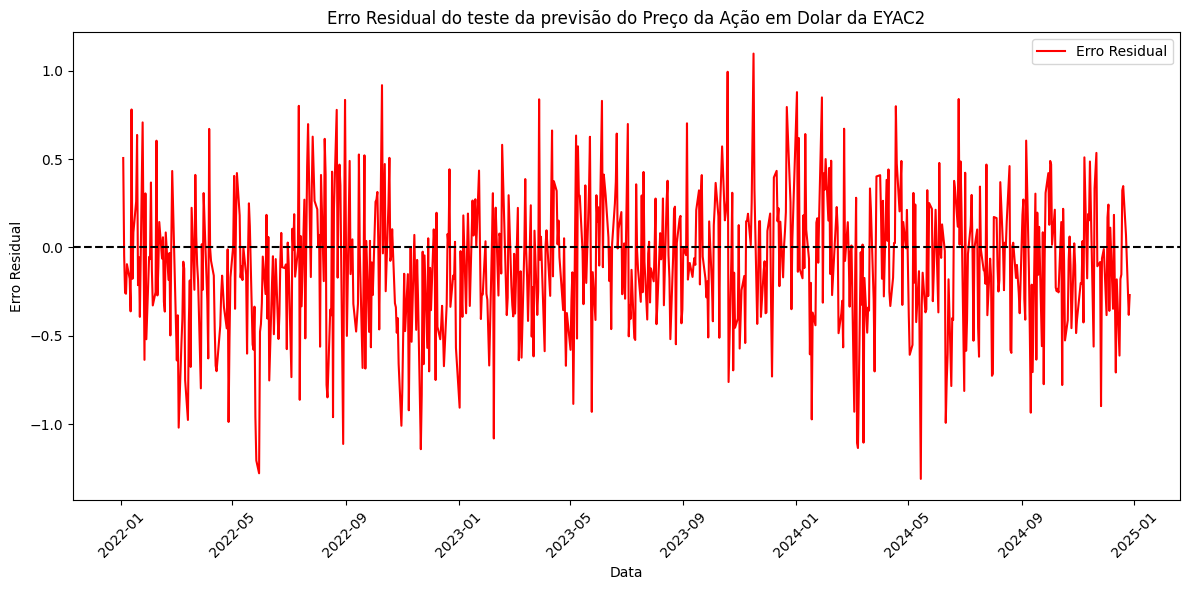

In [134]:
# Calculando os resíduos
residuals = y_test - y_pred_ridge

# Plotando os resíduos
plt.figure(figsize=(12,6))
plt.plot(test['Date'], residuals, label='Erro Residual', color='red')
plt.axhline(0, color='black', linestyle='--')  # Linha horizontal em y=0
plt.legend()
plt.title("Erro Residual do teste da previsão do Preço da Ação em Dolar da EYAC2")
plt.xlabel('Data')
plt.ylabel('Erro Residual')
plt.xticks(rotation=45)  # Para facilitar a leitura das datas
plt.tight_layout()  # Ajuste para que os elementos não se sobreponham
plt.show()


# Previsões 2022 - 2024

## Preparação dos dados

In [135]:
df_preds = pd.read_csv("../../camada_ouro/Join_dataframes_new_end.csv", parse_dates=["Date"])
df_preds['Date'] = pd.to_datetime(df_preds['Date'])
df_preds = df_preds.sort_values('Date')

In [136]:
# Limpeza de colunas com %
df_preds['Change%_Petro'] = df_preds['Change%_Petro'].str.replace('%', '').astype(float) / 100
df_preds['Value_IPCA'] = df_preds['Value_IPCA'].str.replace('%', '').astype(float) / 100
df_preds['Change%_Ibovespa'] = df_preds['Change%_Ibovespa'].astype("str")
df_preds['Change%_Ibovespa'] = df_preds['Change%_Ibovespa'].str.replace('%', '').astype(float) / 100

display(df_preds)

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA
0,2010-01-04,2010-01-04 16:56:00,37.937621,13303743.87,22.005581,81.51,263.54,0.0271,70045.08,0.003999,0.0075
1,2010-01-05,2010-01-05 16:56:00,37.774220,21396519.48,21.927335,81.77,258.89,0.0032,70239.82,-0.037754,0.0075
2,2010-01-06,2010-01-06 16:56:00,38.805357,18720547.15,22.382971,83.18,370.06,0.0172,70729.34,-0.025855,0.0075
3,2010-01-07,2010-01-07 16:56:00,36.425929,10964646.19,20.918813,82.66,246.63,-0.0063,70451.12,0.012930,0.0075
4,2010-01-08,2010-01-08 16:56:00,35.037787,14624078.31,20.148239,82.75,310.38,0.0011,70262.70,0.013341,0.0075
...,...,...,...,...,...,...,...,...,...,...,...
3626,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-0.068388,0.0052
3627,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-0.065514,0.0052
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,0.0052
3629,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-0.057957,0.0052


## Alvo

In [137]:
df_preds['target'] = None 

## Feature Engineering 

### Retorno percentual diário

In [138]:
df_preds['retorno_acao'] = df_preds['Close_Dolar_EYAC2'].pct_change()
df_preds['retorno_petro'] = df_preds['Price_Dolar_Petro'].pct_change()

df_preds.tail()


,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro
3626,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-0.068388,0.0052,None,0.065247,-0.005189
3627,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-0.065514,0.0052,None,0.011586,-0.003043
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,0.0052,None,-0.031813,0.006104
3629,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-0.057957,0.0052,None,-0.054454,0.013722
3630,2024-12-30,2024-12-30 16:56:00,36.614223,22355586.67,6.605965,70.53,93.10,0.0050,120283.40,-0.079271,0.0052,None,0.001331,0.004987


### Médias móveis

In [139]:
df_preds['mm7_acao'] = df_preds['Close_Dolar_EYAC2'].rolling(7).mean()

df_preds.tail()

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,mm7_acao
3626,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-0.068388,0.0052,None,0.065247,-0.005189,6.743059
3627,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-0.065514,0.0052,None,0.011586,-0.003043,6.773660
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,0.0052,None,-0.031813,0.006104,6.841087
3629,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-0.057957,0.0052,None,-0.054454,0.013722,6.802652
3630,2024-12-30,2024-12-30 16:56:00,36.614223,22355586.67,6.605965,70.53,93.10,0.0050,120283.40,-0.079271,0.0052,None,0.001331,0.004987,6.837876


### Volatilidade

In [140]:
df_preds['vol_7_acao'] = df_preds['Close_Dolar_EYAC2'].rolling(7).std()
df_preds['vol_30_acao'] = df_preds['Close_Dolar_EYAC2'].rolling(30).std()


df_preds.tail()

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,mm7_acao,vol_7_acao,vol_30_acao
3626,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-0.068388,0.0052,None,0.065247,-0.005189,6.743059,0.269219,0.353354
3627,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-0.065514,0.0052,None,0.011586,-0.003043,6.773660,0.311161,0.351737
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,0.0052,None,-0.031813,0.006104,6.841087,0.293936,0.351622
3629,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-0.057957,0.0052,None,-0.054454,0.013722,6.802652,0.307383,0.349988
3630,2024-12-30,2024-12-30 16:56:00,36.614223,22355586.67,6.605965,70.53,93.10,0.0050,120283.40,-0.079271,0.0052,None,0.001331,0.004987,6.837876,0.258339,0.353756


### Defasagens

In [141]:
df_preds['lag1_acao'] = df_preds['Close_Dolar_EYAC2'].shift(1)
df_preds['lag60_acao'] = df_preds['Close_Dolar_EYAC2'].shift(60)


df_preds.tail()

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
3626,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-0.068388,0.0052,None,0.065247,-0.005189,6.743059,0.269219,0.353354,6.687504,7.134576
3627,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-0.065514,0.0052,None,0.011586,-0.003043,6.773660,0.311161,0.351737,7.123841,6.470556
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,0.0052,None,-0.031813,0.006104,6.841087,0.293936,0.351622,7.206377,7.059024
3629,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-0.057957,0.0052,None,-0.054454,0.013722,6.802652,0.307383,0.349988,6.977118,6.209937
3630,2024-12-30,2024-12-30 16:56:00,36.614223,22355586.67,6.605965,70.53,93.10,0.0050,120283.40,-0.079271,0.0052,None,0.001331,0.004987,6.837876,0.258339,0.353756,6.597186,6.688640


In [142]:
df_test = df_preds[['Date','target','retorno_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao','lag1_acao', 'lag60_acao']]
display(df_test)

,Date,target,retorno_acao,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
0,2010-01-04,None,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,None,-0.003556,NaN,NaN,NaN,22.005581,NaN
2,2010-01-06,None,0.020779,NaN,NaN,NaN,21.927335,NaN
3,2010-01-07,None,-0.065414,NaN,NaN,NaN,22.382971,NaN
4,2010-01-08,None,-0.036836,NaN,NaN,NaN,20.918813,NaN
...,...,...,...,...,...,...,...,...
3626,2024-12-20,None,0.065247,6.743059,0.269219,0.353354,6.687504,7.134576
3627,2024-12-23,None,0.011586,6.773660,0.311161,0.351737,7.123841,6.470556
3628,2024-12-26,None,-0.031813,6.841087,0.293936,0.351622,7.206377,7.059024
3629,2024-12-27,None,-0.054454,6.802652,0.307383,0.349988,6.977118,6.209937


## Tratamento de Dados

In [143]:
# Copiar o DataFrame original para df_model
df_nan1 = df_preds.copy()

# Preencher os NaN restantes usando o valor posterior (bfill)
df_nan1[['lag1_acao', 'lag60_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 
          'retorno_acao', 'retorno_petro',]] = \
df_nan1[['lag1_acao', 'lag60_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 
          'retorno_acao', 'retorno_petro',]].fillna(method='bfill')

# Verificar se ainda há NaN após preenchimento com bfill 
nan_counts_after_filling = df_nan1[['lag1_acao', 'lag60_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 
          'retorno_acao', 'retorno_petro',]].isna().sum()

print("Após interpolação e bfill, contagem de NaN:", nan_counts_after_filling)

# Visualizar as primeiras linhas após o preenchimento
print(df_nan1.head())

Após interpolação e bfill, contagem de NaN: lag1_acao        0
lag60_acao       0
mm7_acao         0
vol_7_acao       0
vol_30_acao      0
retorno_acao     0
retorno_petro    0
dtype: int64
        Date             Datetime  Close_Real_EYAC2  Volume_EYAC2  \
0 2010-01-04  2010-01-04 16:56:00         37.937621   13303743.87   
1 2010-01-05  2010-01-05 16:56:00         37.774220   21396519.48   
2 2010-01-06  2010-01-06 16:56:00         38.805357   18720547.15   
3 2010-01-07  2010-01-07 16:56:00         36.425929   10964646.19   
4 2010-01-08  2010-01-08 16:56:00         35.037787   14624078.31   

   Close_Dolar_EYAC2  Price_Dolar_Petro  Volume_Petro  Change%_Petro  \
0          22.005581              81.51        263.54         0.0271   
1          21.927335              81.77        258.89         0.0032   
2          22.382971              83.18        370.06         0.0172   
3          20.918813              82.66        246.63        -0.0063   
4          20.148239              8

C:\Users\FM972EJ\AppData\Local\Temp\ipykernel_26636\762502865.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  'retorno_acao', 'retorno_petro',]].fillna(method='bfill')


In [144]:
df_nan1.isna().sum()

Date                    0
Datetime                0
Close_Real_EYAC2        0
Volume_EYAC2            0
Close_Dolar_EYAC2       0
Price_Dolar_Petro       0
Volume_Petro            0
Change%_Petro           0
Índice_Ibovespa         0
Change%_Ibovespa        0
Value_IPCA              0
target               3631
retorno_acao            0
retorno_petro           0
mm7_acao                0
vol_7_acao              0
vol_30_acao             0
lag1_acao               0
lag60_acao              0
dtype: int64

In [145]:
df_preds = df_nan1.copy()

In [146]:
df_test1 = df_preds[['Date','target','retorno_acao','mm7_acao', 'vol_7_acao', 'vol_30_acao', 'lag1_acao','lag60_acao']]
display(df_test1)

,Date,target,retorno_acao,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
0,2010-01-04,None,-0.003556,21.529332,0.891876,1.705580,22.005581,22.005581
1,2010-01-05,None,-0.003556,21.529332,0.891876,1.705580,22.005581,22.005581
2,2010-01-06,None,0.020779,21.529332,0.891876,1.705580,21.927335,22.005581
3,2010-01-07,None,-0.065414,21.529332,0.891876,1.705580,22.382971,22.005581
4,2010-01-08,None,-0.036836,21.529332,0.891876,1.705580,20.918813,22.005581
...,...,...,...,...,...,...,...,...
3626,2024-12-20,None,0.065247,6.743059,0.269219,0.353354,6.687504,7.134576
3627,2024-12-23,None,0.011586,6.773660,0.311161,0.351737,7.123841,6.470556
3628,2024-12-26,None,-0.031813,6.841087,0.293936,0.351622,7.206377,7.059024
3629,2024-12-27,None,-0.054454,6.802652,0.307383,0.349988,6.977118,6.209937


## Definindo Features e Target

In [147]:
# Atualizando as features
feature_names1 = ['lag1_acao',
                  'lag60_acao',
                    'mm7_acao',
                      'vol_7_acao',
                        'vol_30_acao',
                          'Price_Dolar_Petro',
                            'Índice_Ibovespa',
                              'retorno_acao',
                                'retorno_petro']


# Dados de teste (2022 a 2024) com target NaN
test_data = df_preds[df_preds['Date'] >= '2022-01-01']
X_test = test_data[feature_names1]

# Escalonamento dos dados de teste
X_test_scaled = scaler.transform(X_test)

# Fazer previsões para os valores de target ausentes
y_pred = ridge_model.predict(X_test_scaled)

# Preencher o target de 2022 a 2024 com as previsões
df_preds.loc[df_preds['Date'] >= '2022-01-01', 'target'] = y_pred



## Previsão

In [148]:
# Previsões para 2022-2024
future_preds = []

# Selecionar os dados de 2022 a 2024 para previsão
predict_data = df_preds[(df_preds['Date'] >= '2022-01-01') & (df_preds['Date'] <= '2024-12-31')]

# Verificar e preencher valores nulos nas features (se necessário)
predict_data[feature_names1] = predict_data[feature_names1].fillna(predict_data[feature_names1].mean())

# Normalizar as features do conjunto de previsão
X_predict = predict_data[feature_names1]
X_predict_scaled = scaler.transform(X_predict)

# Realizar as previsões
predictions = ridge_model.predict(X_predict_scaled)

# Armazenar as previsões e atualizar no DataFrame
for idx, predicted_target in zip(predict_data.index, predictions):
    df_preds.at[idx, 'target'] = predicted_target
    future_preds.append((df_preds.at[idx, 'Date'], predicted_target))

# Exibir as previsões
future_preds_df = pd.DataFrame(future_preds, columns=['Date', 'Predicted_Target'])
display(future_preds_df)

C:\Users\FM972EJ\AppData\Local\Temp\ipykernel_26636\1668339731.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data[feature_names1] = predict_data[feature_names1].fillna(predict_data[feature_names1].mean())


,Date,Predicted_Target
0,2022-01-03,5.557534
1,2022-01-04,5.743712
2,2022-01-05,5.736908
3,2022-01-06,5.705155
4,2022-01-07,5.623988
...,...,...
742,2024-12-20,6.858723
743,2024-12-23,6.905887
744,2024-12-26,6.978883
745,2024-12-27,6.875421


In [149]:
df_preds.isna().sum()

Date                    0
Datetime                0
Close_Real_EYAC2        0
Volume_EYAC2            0
Close_Dolar_EYAC2       0
Price_Dolar_Petro       0
Volume_Petro            0
Change%_Petro           0
Índice_Ibovespa         0
Change%_Ibovespa        0
Value_IPCA              0
target               2884
retorno_acao            0
retorno_petro           0
mm7_acao                0
vol_7_acao              0
vol_30_acao             0
lag1_acao               0
lag60_acao              0
dtype: int64

## Comparação entre o Real e o Preditivo

In [150]:
# Comparando o 'target' no df_model com o 'predicted_target' no df_preds

# Obter os dados de df_model (valores reais) e df_preds (valores previstos)
real_data_model = df_model[(df_model['Date'] >= '2022-01-01') & (df_model['Date'] <= '2024-12-31')]
pred_data_preds = df_preds[(df_preds['Date'] >= '2022-01-01') & (df_preds['Date'] <= '2024-12-31')]

# Realizar o merge para comparar 'target' (real) e 'predicted_target' (previsto)
comparison_df = pd.merge(real_data_model[['Date', 'target']], pred_data_preds[['Date', 'target']], on='Date', how='left', suffixes=('_Real', '_Predicted'))

# Exibir a comparação
display(comparison_df)

,Date,target_Real,target_Predicted
0,2022-01-03,6.064248,5.557534
1,2022-01-04,5.698707,5.743712
2,2022-01-05,5.479838,5.736908
3,2022-01-06,5.443258,5.705155
4,2022-01-07,5.529412,5.623988
...,...,...,...
741,2024-12-19,7.123841,6.800108
742,2024-12-20,7.206377,6.858723
743,2024-12-23,6.977118,6.905887
744,2024-12-26,6.597186,6.978883


## Visualização da previsão

Tamanho de test_filtered['Date']:  746
Tamanho de y_pred_ridge_filtered:  746


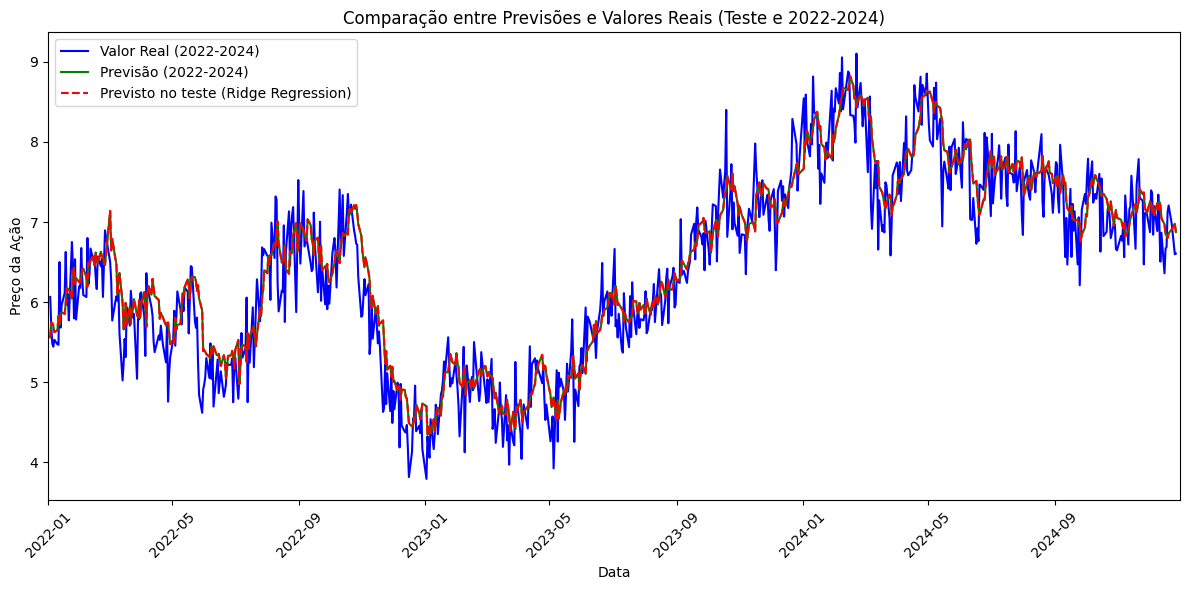

In [151]:
# Defina o intervalo de tempo desejado para a visualização
start_date = '2022-01-01'  # Data de início
end_date = '2024-12-31'    # Data de término

comparison_df_filtered = comparison_df[(comparison_df['Date'] >= start_date) & (comparison_df['Date'] <= end_date)]
# Filtrar tanto as datas de teste quanto as previsões pelo mesmo intervalo
test_filtered = test[(test['Date'] >= start_date) & (test['Date'] <= end_date)]

# Ajuste y_pred_ridge para ter as previsões correspondentes a test_filtered
y_pred_ridge_filtered = y_pred_ridge[:len(test_filtered)]  # Garantir que as previsões correspondam ao número de amostras em test_filtered

# Verificar os tamanhos após a filtragem
print("Tamanho de test_filtered['Date']: ", len(test_filtered['Date']))
print("Tamanho de y_pred_ridge_filtered: ", len(y_pred_ridge_filtered))


# Verifique se as datas e previsões têm o mesmo tamanho
if len(test_filtered['Date']) == len(y_pred_ridge_filtered):
    # Plotando as previsões vs reais para os dados de teste e as previsões para 2022-2024
    # Plotando as previsões vs reais para os dados de teste e as previsões para 2022-2024
    plt.figure(figsize=(12, 6))

    # Plotando os valores reais de 2022 a 2024 (com base no comparison_df)
    plt.plot(comparison_df_filtered['Date'], comparison_df_filtered['target_Real'], label='Valor Real (2022-2024)', color='blue')
    plt.plot(comparison_df_filtered['Date'], comparison_df_filtered['target_Predicted'], label='Previsão (2022-2024)', color='green')

    # Plotando as previsões feitas pelo modelo para o teste (Ridge Regression ou outro)
    plt.plot(test_filtered['Date'], y_pred_ridge_filtered, label='Previsto no teste (Ridge Regression)', linestyle='--', color='red')

    # Adicionando título e rótulos
    plt.legend()
    plt.title('Comparação entre Previsões e Valores Reais (Teste e 2022-2024)')
    plt.xlabel('Data')
    plt.ylabel('Preço da Ação')

    # Ajustando a exibição das datas
    plt.xticks(rotation=45)

    # Ajuste para que os elementos não se sobreponham
    plt.tight_layout()

    # Ajustando o intervalo de tempo no eixo x
    plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

    # Mostrar o gráfico
    plt.show()

else:
    print("Erro: As dimensões de 'test_filtered['Date']' e 'y_pred_ridge' não coincidem!")


## Erro Relativo

In [152]:
# Calcular o erro percentual total (erro percentual global)
total_error_percentage = (abs(comparison_df['target_Real'] - comparison_df['target_Predicted']).sum() / abs(comparison_df['target_Real']).sum()) * 100

# Exibir o erro percentual total
print(f'Erro Percentual Total: {total_error_percentage:.2f}%')


Erro Percentual Total: 4.98%


In [153]:
# Calculando o erro percentual absoluto (percentual de erro)
comparison_df['percentual_erro'] = (abs(comparison_df['target_Real'] - comparison_df['target_Predicted']) / abs(comparison_df['target_Real'])) * 100

# Calcular o erro percentual médio (MAPE)
mape = comparison_df['percentual_erro'].mean()
print(f'Média do Erro Percentual Absoluto (MAPE): {mape:.2f}%')


Média do Erro Percentual Absoluto (MAPE): 5.23%


In [154]:
# Exibindo os erros percentuais para cada previsão
display(comparison_df[['Date', 'target_Real', 'target_Predicted', 'percentual_erro']])

# Salvando os erros percentuais em um arquivo CSV
comparison_df[['Date', 'target_Real', 'target_Predicted', 'percentual_erro']].to_csv('../../camada_ouro/comparison_real_vs_preds_vs_erros_Dolar.csv', index=False)


,Date,target_Real,target_Predicted,percentual_erro
0,2022-01-03,6.064248,5.557534,8.355763
1,2022-01-04,5.698707,5.743712,0.789744
2,2022-01-05,5.479838,5.736908,4.691212
3,2022-01-06,5.443258,5.705155,4.811412
4,2022-01-07,5.529412,5.623988,1.710421
...,...,...,...,...
741,2024-12-19,7.123841,6.800108,4.544365
742,2024-12-20,7.206377,6.858723,4.824263
743,2024-12-23,6.977118,6.905887,1.020915
744,2024-12-26,6.597186,6.978883,5.785751


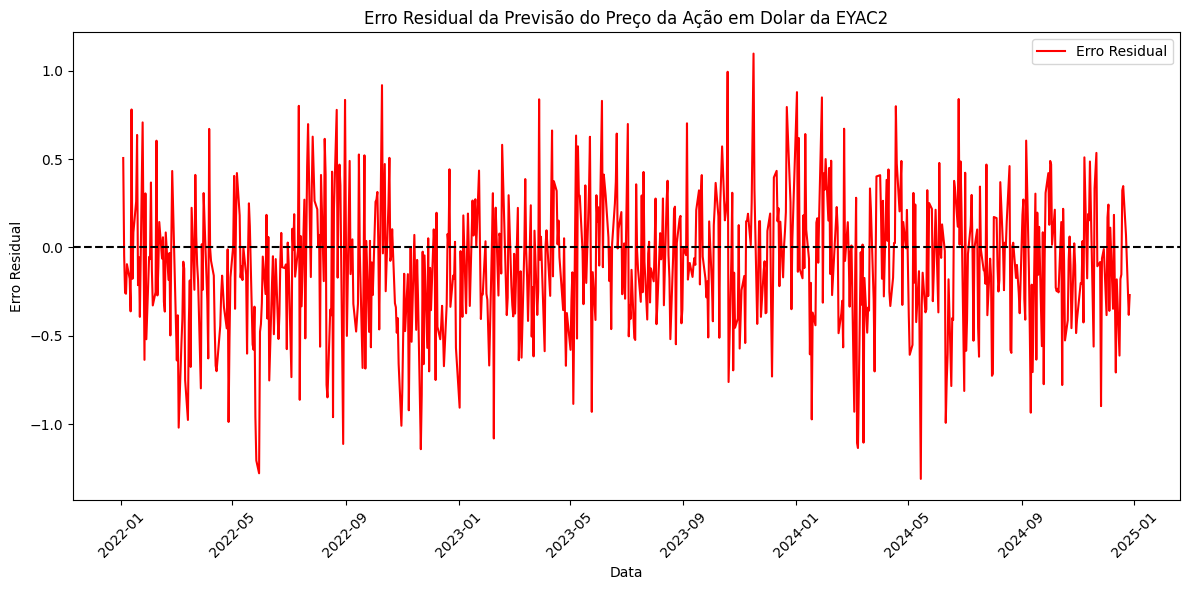

In [155]:
# Calculando os resíduos
residuals = y_test - y_pred_ridge_filtered


# Plotando os resíduos
plt.figure(figsize=(12,6))
plt.plot(test['Date'], residuals, label='Erro Residual', color='red')
plt.axhline(0, color='black', linestyle='--')  # Linha horizontal em y=0
plt.legend()
plt.title("Erro Residual da Previsão do Preço da Ação em Dolar da EYAC2")
plt.xlabel('Data')
plt.ylabel('Erro Residual')
plt.xticks(rotation=45)  # Para facilitar a leitura das datas
plt.tight_layout()  # Ajuste para que os elementos não se sobreponham
plt.show()
